In [10]:
import sys
sys.path.append("/users/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/model")

import os.path as osp
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.utils import k_hop_subgraph, from_networkx
import pickle
import networkx as nx
from math import floor
from tqdm.autonotebook import tqdm
import seaborn as sns
from scipy.sparse import coo_matrix,csr_matrix

import sys
sys.path.append("..")

from model.BayesExplainer import BayesExplainer
from model.samplers.NFSampler import NFSampler
from model.samplers.SpikeSlabSampler import SpikeSlabSampler
from model.samplers.RandomWalkSampler import RandomWalkSampler
from model.samplers.ConstrainedRandomWalkSampler import ConstrainedRandomWalkSampler

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

G = nx.read_gpickle('data/syn3_G.pickle')
with open('data/syn3_lab.pickle', 'rb') as f:
    labels = pickle.load(f)

x = torch.tensor([x[1]['feat'] for x in G.nodes(data=True)])
edge_index = torch.tensor([x for x in G.edges])
edge_index_flipped = edge_index[:, [1, 0]]
edge_index = torch.cat((edge_index, edge_index_flipped))
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index.T, y=y)

class Net(torch.nn.Module):
    def __init__(self, x=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(10, x)
        self.conv2 = GCNConv(x, x)
        self.conv3 = GCNConv(x, x)
        self.fc = torch.nn.Linear(x, max(y).tolist()+1)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x, edge_index = data.x, data.edge_index

model = Net(x=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_loss = 100
pbar = tqdm(range(10000))
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

    # Testing step
    model.eval()
    best_loss = loss if loss < best_loss else best_loss
    pbar.set_description("Acc -> %.4f" % torch.mean((torch.argmax(log_logits, dim=1) == data.y).float()).item())

/gpfs_home/spate116/ml/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


Explain node 529: 100%|██████████| 1000/1000 [00:03<00:00, 313.90it/s]


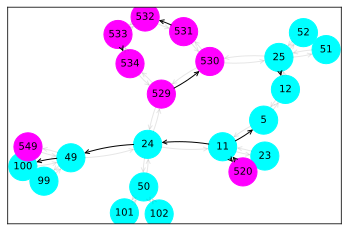

In [11]:
explainer = GNNExplainer(model, epochs=1000)
node_idx = 529
k = 3
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

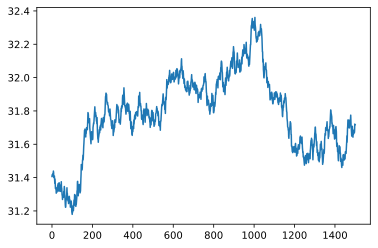

In [12]:
k = 3
splines = 8
sampler = NFSampler("syn3_nf_sampler", splines, True, 5, 1.5, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2000, lr=0.5, window=500, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

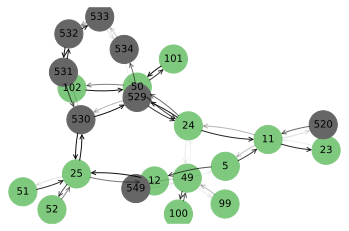

In [13]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

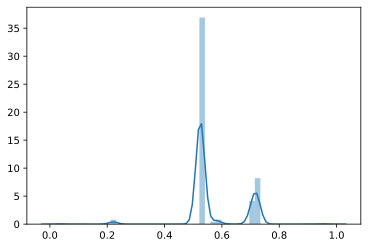

In [14]:
sns.distplot(explainer.sampler.flow_dist.rsample(torch.Size([10000,])).sigmoid()[:, 7].detach().numpy())

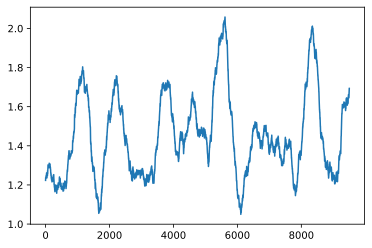

In [15]:
sampler = SpikeSlabSampler("syn3_spike_slab", 0.25, 1, 5, 10, 1)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=10000, lr=0.05, window=500, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

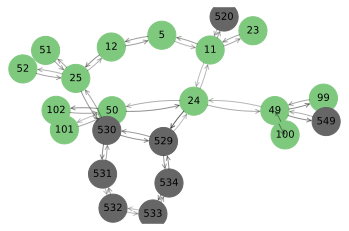

In [16]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [17]:
edge_mask

tensor([0.2913, 0.3889, 0.3392, 0.2543, 0.3332, 0.4331, 0.3305, 0.3175, 0.6098,
        0.3499, 0.3020, 0.4022, 0.4621, 0.3957, 0.4500, 0.2551, 0.4324, 0.3934,
        0.4067, 0.4530, 0.2615, 0.2868, 0.3330, 0.3834, 0.3798, 0.3620, 0.2849,
        0.3075, 0.3057, 0.2842, 0.4427, 0.2575, 0.3554, 0.3607, 0.3449, 0.3546,
        0.3999, 0.3101, 0.3512, 0.3668, 0.4329, 0.4411, 0.3391, 0.3525, 0.2729,
        0.4432], grad_fn=<AddBackward0>)

In [18]:
sampler = RandomWalkSampler("syn3_random_walk", 0.5)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=5000, lr=0.1, window=500, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

IndexError: list index out of range

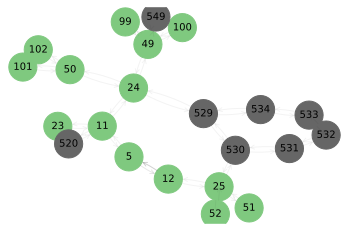

In [ ]:
edge_mask, sample_dists = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.0020, 0.0950, 0.0020, 0.0000, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0020, 0.1860, 0.0020, 0.0000,
        0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [ ]:
explainer.sampler.ret_probs(explainer)